In [1]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
from time import time

from matplotlib import pyplot as plt

## Axi4lite inteface

## CNN

### Load the overlay

In [2]:
from pynq import Overlay

overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/PYNQ_CNN.bit')

In [3]:
overlay.is_loaded()

True

### Check the clocks

In [4]:
from pynq import Clocks

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 100.000000MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


### Define the CNN ip

Here we define the ip and diplay the two memory mapped port addresses

In [5]:
ip = overlay.CNN_MNIST_0

In [6]:
ip.register_map

RegisterMap {
  Memory_in_V = Register(value=0),
  Memory_out_V = Register(value=37945396)
}

In [7]:
print("Memory_in_V.address: " + str(ip.register_map.Memory_in_V.address))
print("Memory_out_V.address: " + str(ip.register_map.Memory_out_V.address))

Memory_in_V.address: 1024
Memory_out_V.address: 2048


In [8]:
in_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_in_V.address, 196 * 4)
ou_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_out_V.address, 5 * 4)

### Load a fraction of the test dataset

In [9]:
X = np.load('./X_test.npy').astype(np.float32)
X = X[:5]

In [10]:
def encode_matrix(matrix):
    X_ca = np.reshape(matrix*2**5, (196,4))
    X_ca = X_ca.astype(np.uint32)
    X_enc = X_ca[:,0] + (X_ca[:,1]<<8) + (X_ca[:,2]<<16) + (X_ca[:,3]<<24)
    return X_enc


def decode(yi):
    return yi * 2**-10

def decode_pair(yab):
    ya = (yab & 0x0000ffff) * 2**-10
    ya = ya if ya < 32 else ya - 64
    yb = (yab & 0xffff0000) * 2**-26
    yb = yb if yb < 32 else yb - 64
    return ya, yb

def get_output(mmio):
    y = np.zeros(10)
    for i in range(5):
        yi = decode_pair(mmio.read(4 * i))
        y[2*i], y[2*i+1] = yi[0], yi[1]
    return y[:10]

#def decode_output(y):
    

def print_img(matrix, title="Label"):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

    
def print_dt(timea, timeb, N):
    dt = (timeb - timea) 
    rate = N / dt
    print("Classified {} images in {} seconds ({} inferences / s)".format(N, dt, rate))
    print("----------------------------------------------------------------------------")
    print("{} s/inference ".format(1/rate))       

### Test
Siple test on the first five images

In [11]:
y = []
timea = time()
for Xi in X:
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
timeb = time()
ips = X.shape[0]/(timeb-timea) #images per second
print('Throughput = %f image/s' % ips)

Throughput = 102.562257 image/s


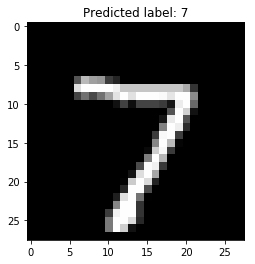

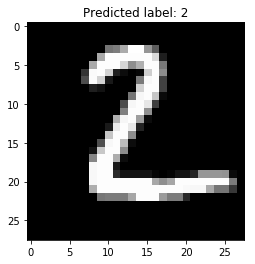

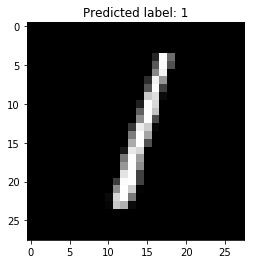

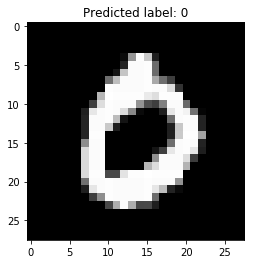

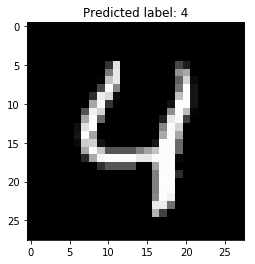

In [12]:
for i in range(X.shape[0]):
    img_title = ('Predicted label: %d' % np.argmax(np.array(y[i])))
    print_img(X[i], img_title)

### Whole dataset computation

In [13]:
N_callback = 500

X = np.load('./X_test.npy').astype(np.float32)
y = []
timea = time()
time0 = time()
for iXi, Xi in enumerate(X):
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
    if (iXi % N_callback == 0) & (iXi != 0):
        time1 = time()
        print_dt(time0, time1, N_callback)
        time0 = time()

timeb = time()
print_dt(timea, timeb, X.shape[0])
np.save('y_pynq_CNN.npy', y)

Classified 500 images in 3.7906312942504883 seconds (131.90415030825721 inferences / s)
----------------------------------------------------------------------------
0.007581262588500976 s/inference 
Classified 500 images in 3.8317949771881104 seconds (130.48714844522175 inferences / s)
----------------------------------------------------------------------------
0.00766358995437622 s/inference 
Classified 500 images in 3.944728374481201 seconds (126.7514395248465 inferences / s)
----------------------------------------------------------------------------
0.007889456748962402 s/inference 
Classified 500 images in 3.9534668922424316 seconds (126.47127537127213 inferences / s)
----------------------------------------------------------------------------
0.007906933784484864 s/inference 
Classified 500 images in 3.953436851501465 seconds (126.47223638088626 inferences / s)
----------------------------------------------------------------------------
0.00790687370300293 s/inference 
Classified

## DNN 

In [14]:
from pynq import Overlay

overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/PYNQ_DNN.bit')

In [15]:
overlay.is_loaded()

True

In [16]:
from pynq import Clocks

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 100.000000MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [17]:
ip = overlay.DNN_MNIST_0

In [18]:
ip.register_map

RegisterMap {
  Memory_in_V = Register(value=0),
  Memory_out_V = Register(value=9437208)
}

In [19]:
print("Memory_in_V.address: " + str(ip.register_map.Memory_in_V.address))
print("Memory_out_V.address: " + str(ip.register_map.Memory_out_V.address))

Memory_in_V.address: 1024
Memory_out_V.address: 2048


In [20]:
in_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_in_V.address, 196 * 4)
ou_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_out_V.address, 5 * 4)

In [21]:
X = np.load('./X_test.npy').astype(np.float32)
X = X[:5]

In [22]:
y = []
timea = time()
for Xi in X:
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
timeb = time()
ips = X.shape[0]/(timeb-timea) #images per second
print('Throughput = %f image/s' % ips)

Throughput = 76.740328 image/s


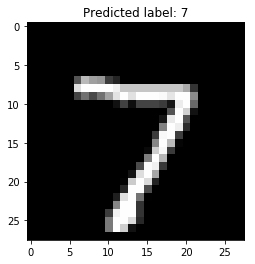

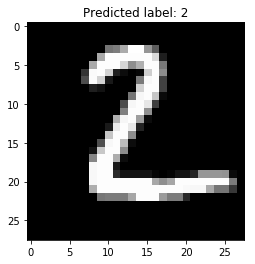

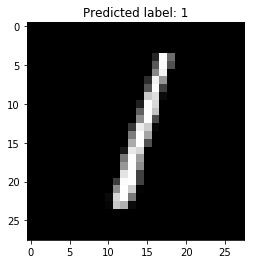

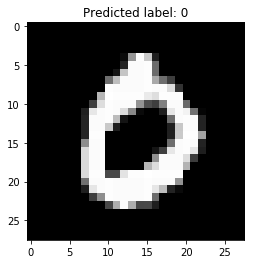

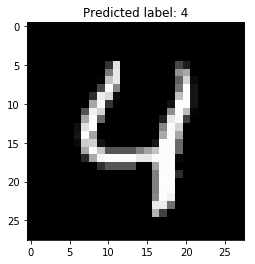

In [23]:
for i in range(X.shape[0]):
    img_title = ('Predicted label: %d' % np.argmax(np.array(y[i])))
    print_img(X[i], img_title)

In [24]:
N_callback = 500

X = np.load('./X_test.npy').astype(np.float32)
y = []
timea = time()
time0 = time()
for iXi, Xi in enumerate(X):
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
    if (iXi % N_callback == 0) & (iXi != 0):
        time1 = time()
        print_dt(time0, time1, N_callback)
        time0 = time()

timeb = time()
print_dt(timea, timeb, X.shape[0])
np.save('y_pynq_DNN.npy', y)

Classified 500 images in 3.9998793601989746 seconds (125.0037701074883 inferences / s)
----------------------------------------------------------------------------
0.007999758720397949 s/inference 
Classified 500 images in 3.842712163925171 seconds (130.11643304797275 inferences / s)
----------------------------------------------------------------------------
0.007685424327850342 s/inference 
Classified 500 images in 3.84317946434021 seconds (130.10061191244398 inferences / s)
----------------------------------------------------------------------------
0.00768635892868042 s/inference 
Classified 500 images in 3.834834337234497 seconds (130.38372874291528 inferences / s)
----------------------------------------------------------------------------
0.007669668674468995 s/inference 
Classified 500 images in 3.840297222137451 seconds (130.19825578024077 inferences / s)
----------------------------------------------------------------------------
0.007680594444274902 s/inference 
Classified 5

## Axis interface with DMA

## CNN

In [1]:
from pynq import DefaultHierarchy, DefaultIP, allocate
from pynq import Overlay
from datetime import datetime
import pynq.lib.dma
import numpy as np

import matplotlib.pyplot as plt

class NeuralNetworkOverlay(Overlay):
    def __init__(self, bitfile_name, dtbo=None, download=True, ignore_version=False, device=None):
        
        super().__init__(bitfile_name, dtbo=dtbo, download=download, ignore_version=ignore_version, device=device)
        
    def _print_dt(self, timea, timeb, N):
        dt      = (timeb - timea)
        dts = dt.seconds + dt.microseconds * 10**-6
        rate = N / dts
        print("Classified {} samples in {} seconds ({} inferences / s)".format(N, dts, rate))
        print("Or {} us / inferences".format(1/rate*1e6))
        return dts, rate
    def predict(self, X, y_shape, dtype=np.float32, debug=None, profile=False, encode=None, decode=None):
        """
        Obtain the predictions of the NN implemented in the FPGA.
        Parameters:
        - X : the input vector. Should be numpy ndarray.
        - y_shape : the shape of the output vector. Needed to the accelerator to set the TLAST bit properly and
                    for sizing the output vector shape.
        - dtype : the data type of the elements of the input/output vectors. 
                  Note: it should be set depending on the interface of the accelerator; if it uses 'float' 
                  types for the 'data' AXI-Stream field, 'np.float32' dtype is the correct one to use. 
                  Instead if it uses 'ap_fixed<A,B>', 'np.intA' is the correct one to use (note that A cannot
                  any integer value, but it can assume {..., 8, 16, 32, ...} values. Check `numpy` 
                  doc for more info).
                  In this case the encoding/decoding has to be computed by the PS. For example for 
                  'ap_fixed<16,6>' type the following 2 functions are the correct one to use for encode/decode 
                  'float' -> 'ap_fixed<16,6>':
                  ```
                    def encode(xi):
                        return np.int16(round(xi * 2**10)) # note 2**10 = 2**(A-B)
                    def decode(yi):
                        return yi * 2**-10
                    encode_v = np.vectorize(encode) # to apply them element-wise
                    decode_v = np.vectorize(decode)
                  ```
        - profile : boolean. Set it to `True` to print the performance of the algorithm in term of `inference/s`.
        - encode/decode: function pointers. See `dtype` section for more information.
        - return: an output array based on `np.ndarray` with a shape equal to `y_shape` and a `dtype` equal to
                  the namesake parameter.
        """
        if profile:
            timea = datetime.now()
        if encode is not None:
            X = encode(X)
        with allocate(shape=X.shape, dtype=dtype) as input_buffer, \
             allocate(shape=y_shape, dtype=dtype) as output_buffer:
            input_buffer[:] = X 
            self.hier_0.axi_dma_0.sendchannel.transfer(input_buffer)
            self.hier_0.axi_dma_0.recvchannel.transfer(output_buffer)
            if debug:
                print("Transfer OK")
            self.hier_0.axi_dma_0.sendchannel.wait()
            #self.hier_0.axi_dma_0.sendchannel.wait_async()
            if debug:
                print("Send OK")
            self.hier_0.axi_dma_0.recvchannel.wait()
            #self.hier_0.axi_dma_0.recvchannel.wait_async()
            if debug:
                print("Receive OK")
            result = output_buffer.copy()
            input_buffer.flush()
            #output_buffer.flush()
        if decode is not None:
            result = decode(result)
        if profile:
            timeb = datetime.now()
            dts, rate = self._print_dt(timea, timeb, len(X))
            return result, dts, rate
        return result
    
def print_img(matrix, title="Label"):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [2]:
X = np.load('./X_test.npy').astype(np.float32)

In [3]:
overlay = NeuralNetworkOverlay(bitfile_name='/home/xilinx/pynq/overlays/User_overlay/PYNQ_DMA_CNN_float.bit')
overlay.is_loaded()

True

In [4]:
from pynq import Clocks

Clocks.fclk0_mhz = 200

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 200.000000MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [10]:
y, _, _ = overlay.predict(X=X, y_shape=(X.shape[0],10), dtype=np.float32, profile=True, debug=False)

Classified 10000 samples in 0.8662599999999999 seconds (11543.878281347403 inferences / s)
Or 86.62599999999999 us / inferences


In [11]:
rate_v  = []
in_size = np.linspace(X.shape[0]/50, X.shape[0], 50, dtype=np.int32)
for i in range(50):
    N = int(((i+1)*X.shape[0]/50))
    in_X = X[:N]
    y, _, rate = overlay.predict(X=in_X, y_shape=(in_X.shape[0],10), dtype=np.float32, profile=True, debug=False)
    rate_v.append(rate)

Classified 200 samples in 0.096361 seconds (2075.5284814395864 inferences / s)
Or 481.805 us / inferences
Classified 400 samples in 0.08839699999999999 seconds (4525.040442548956 inferences / s)
Or 220.99249999999998 us / inferences
Classified 600 samples in 0.09887399999999999 seconds (6068.329388919231 inferences / s)
Or 164.79 us / inferences
Classified 800 samples in 0.11441599999999999 seconds (6992.029086841002 inferences / s)
Or 143.02 us / inferences
Classified 1000 samples in 0.1305 seconds (7662.835249042146 inferences / s)
Or 130.5 us / inferences
Classified 1200 samples in 0.150718 seconds (7961.889090884964 inferences / s)
Or 125.59833333333333 us / inferences
Classified 1400 samples in 0.159247 seconds (8791.374405797284 inferences / s)
Or 113.74785714285714 us / inferences
Classified 1600 samples in 0.179395 seconds (8918.866189135706 inferences / s)
Or 112.121875 us / inferences
Classified 1800 samples in 0.193297 seconds (9312.0948592063 inferences / s)
Or 107.38722222

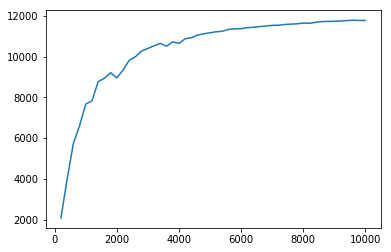

In [7]:
plt.plot(in_size, rate_v)

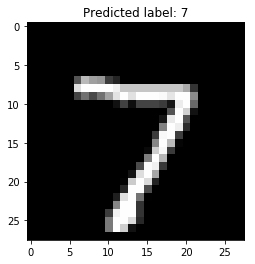

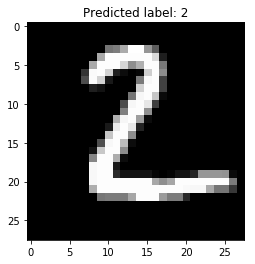

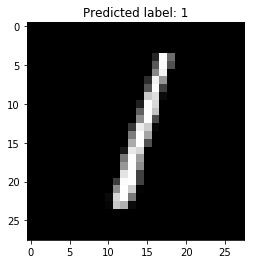

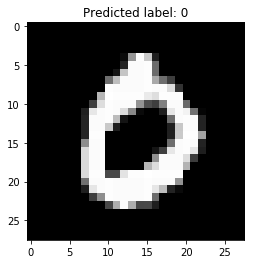

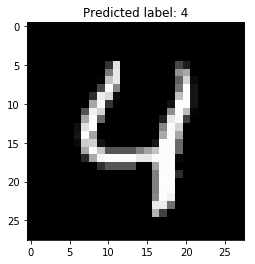

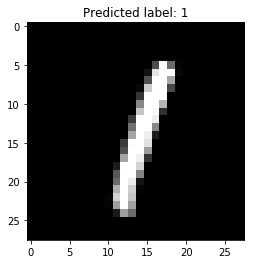

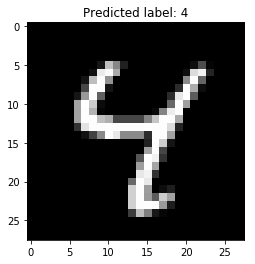

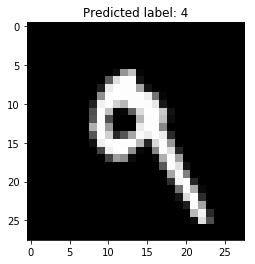

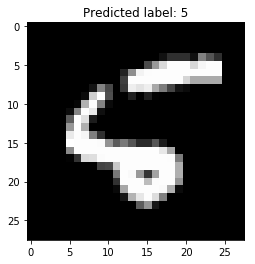

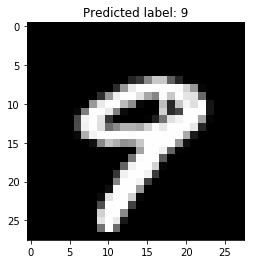

In [12]:
for i in range(10):
    img_title = ('Predicted label: %d' % np.argmax(np.array(y[i])))
    print_img(X[i], img_title)

In [19]:
np.save('y_pynq_CNN.npy', y)

## DNN

In [3]:
overlay = NeuralNetworkOverlay(bitfile_name='/home/xilinx/pynq/overlays/User_overlay/PYNQ_DMA_DNN_float.bit')
overlay.is_loaded()

True

In [5]:
from pynq import Clocks

Clocks.fclk0_mhz = 166

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 166.666667MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [7]:
rate_v  = []
in_size = np.linspace(X.shape[0]/50, X.shape[0], 50, dtype=np.int32)
for i in range(50):
    N = int(((i+1)*X.shape[0]/50))
    in_X = X[:N]
    y, _, rate = overlay.predict(X=in_X, y_shape=(in_X.shape[0],10), dtype=np.float32, profile=True, debug=False)
    rate_v.append(rate)

Classified 200 samples in 0.09989999999999999 seconds (2002.0020020020022 inferences / s)
Or 499.49999999999994 us / inferences
Classified 400 samples in 0.08945199999999999 seconds (4471.671958145151 inferences / s)
Or 223.63 us / inferences
Classified 600 samples in 0.102028 seconds (5880.73862077077 inferences / s)
Or 170.04666666666665 us / inferences
Classified 800 samples in 0.115753 seconds (6911.267958497836 inferences / s)
Or 144.69125 us / inferences
Classified 1000 samples in 0.11763799999999999 seconds (8500.65455040038 inferences / s)
Or 117.638 us / inferences
Classified 1200 samples in 0.131931 seconds (9095.663642358506 inferences / s)
Or 109.9425 us / inferences
Classified 1400 samples in 0.13708 seconds (10213.014298220018 inferences / s)
Or 97.91428571428571 us / inferences
Classified 1600 samples in 0.14959999999999998 seconds (10695.187165775402 inferences / s)
Or 93.5 us / inferences
Classified 1800 samples in 0.158558 seconds (11352.312718374349 inferences / s)
O

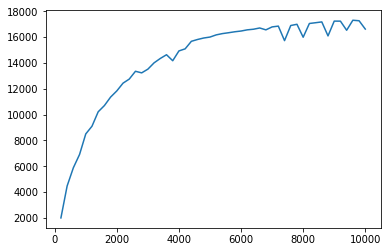

In [8]:
plt.plot(in_size, rate_v)

In [9]:
y, _, _ = overlay.predict(X=X, y_shape=(X.shape[0],10), dtype=np.float32, profile=True, debug=False)

Classified 10000 samples in 0.592712 seconds (16871.600372524936 inferences / s)
Or 59.2712 us / inferences


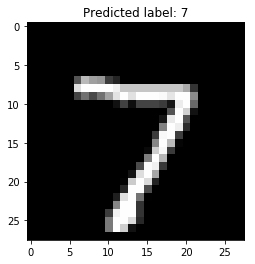

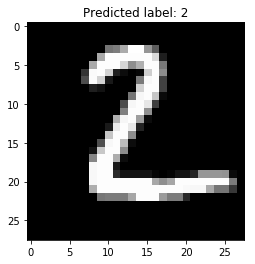

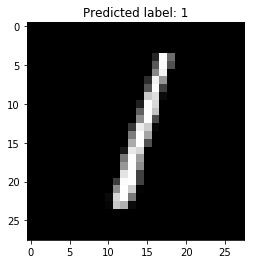

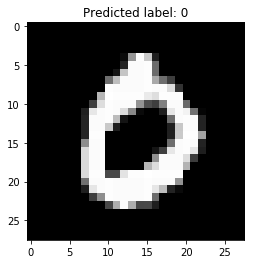

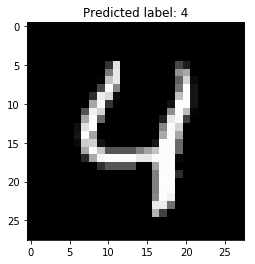

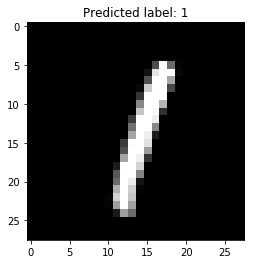

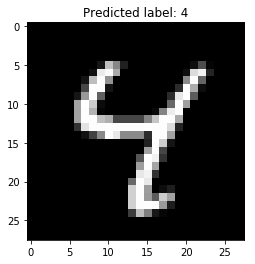

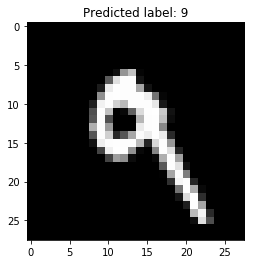

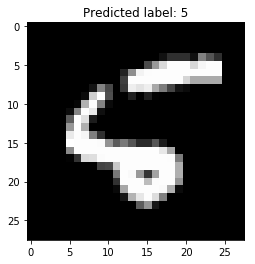

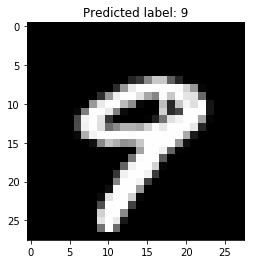

In [10]:
for i in range(10):
    img_title = ('Predicted label: %d' % np.argmax(np.array(y[i])))
    print_img(X[i], img_title)

In [11]:
np.save('y_pynq_DNN.npy', y)